In [1]:
import $ivy.`org.apache.spark::spark-sql:2.4.3`


import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.expressions.Window



//Reducir numero logs
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)


//For adding extra dependenies
import $ivy.`org.typelevel::cats-core:1.6.0`

//Plotly
import $ivy.`org.plotly-scala::plotly-almond:0.7.1`
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._


//Iniciamos session de Spark
val spark = {
  NotebookSparkSession.builder()
     .master("local[*]")
    //.config("spark.executor.instances", "4") // Número de ejecutores
    //.config("spark.executor.memory", "4g") // Memoria por ejecutor
    //.config("spark.executor.cores", "2") // Núcleos por ejecutor
    //.config("spark.driver.memory", "4g") // Memoria del driver
    //.config("spark.sql.shuffle.partitions", "8") // Número de particiones para operaciones de shuffle
    .getOrCreate()
}
import spark.implicits._

Downloaded https://repo1.maven.org/maven2/org/apache/spark/spark-sql_2.12/2.4.3/spark-sql_2.12-2.4.3.pom
Downloaded https://repo1.maven.org/maven2/sh/almond/almond-spark_2.12/0.8.2/almond-spark_2.12-0.8.2.pom
Downloaded https://repo1.maven.org/maven2/org/apache/spark/spark-parent_2.12/2.4.3/spark-parent_2.12-2.4.3.pom
Downloaded https://repo1.maven.org/maven2/org/apache/apache/18/apache-18.pom
Downloaded https://repo1.maven.org/maven2/sh/almond/ammonite-spark_2.12/0.7.2/ammonite-spark_2.12-0.7.2.pom
Downloaded https://repo1.maven.org/maven2/org/apache/parquet/parquet-hadoop/1.10.1/parquet-hadoop-1.10.1.pom
Downloaded https://repo1.maven.org/maven2/org/apache/spark/spark-sketch_2.12/2.4.3/spark-sketch_2.12-2.4.3.pom
Downloaded https://repo1.maven.org/maven2/org/apache/xbean/xbean-asm6-shaded/4.8/xbean-asm6-shaded-4.8.pom
Downloaded https://repo1.maven.org/maven2/org/apache/parquet/parquet-column/1.10.1/parquet-column-1.10.1.pom
Downloaded https://repo1.maven.org/maven2/org/apache/spark/

Loading spark-stubs


Downloaded https://repo1.maven.org/maven2/sh/almond/spark-stubs_24_2.12/0.7.2/spark-stubs_24_2.12-0.7.2.pom
Downloaded https://repo1.maven.org/maven2/sh/almond/spark-stubs_24_2.12/0.7.2/spark-stubs_24_2.12-0.7.2-sources.jar
Downloaded https://repo1.maven.org/maven2/sh/almond/spark-stubs_24_2.12/0.7.2/spark-stubs_24_2.12-0.7.2.jar


Getting spark JARs
Creating SparkSession


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


Spark UI

import $ivy.$                                  



import org.apache.spark.sql._

import org.apache.spark.sql.functions._

import org.apache.spark.sql.expressions.Window



//Reducir numero logs

import org.apache.log4j.{Level, Logger}

import $ivy.$                               

//Plotly

import $ivy.$                                      

import plotly._, plotly.element._, plotly.layout._, plotly.Almond._


//Iniciamos session de Spark

spark: SparkSession = org.apache.spark.sql.SparkSession@69770f84
import spark.implicits._

In [2]:
val filePathBalance = "../../data/parquet/dsBalanceNacional11-24.parquet"         
val datosBalance: DataFrame = spark.read
  //.option("header", "true") // Si el archivo tiene un encabezado
  //.option("inferSchema", "true") // Para inferir automáticamente el esquema
  //.csv(filePath)
    .parquet(filePathBalance)

parquet at cmd1.sc:6

1 / 1

filePathBalance: String = "../../data/parquet/dsBalanceNacional11-24.parquet"
datosBalance: DataFrame = [Familia: string, Tipo: string ... 5 more fields]

In [3]:
datosBalance.printSchema()

root
 |-- Familia: string (nullable = true)
 |-- Tipo: string (nullable = true)
 |-- Compuesto: boolean (nullable = true)
 |-- Porcentaje: double (nullable = true)
 |-- Valor: double (nullable = true)
 |-- Fecha: timestamp (nullable = true)
 |-- BajasEmisiones: boolean (nullable = true)



### Calculo real del porcentaje que aporta cada fuente de energía al total de la generación diaria

In [4]:
val ventana = Window.partitionBy("Fecha")
val datosBalanceDiarios = datosBalance
    .withColumn("PorcentajeSobreFamilia", round($"Porcentaje" * 100,2) )
    .drop("Porcentaje")
    .withColumn(
            "TotalGenerado", 
            round(sum(when(!$"Compuesto" && $"Familia" =!= "Demanda" ,$"Valor").otherwise(0)).over(ventana),2)
    )
    .withColumn("PorcentajeSobreTotal", round($"Valor" / $"TotalGenerado" * 100,2))
    

datosBalanceDiarios.orderBy(desc("Fecha")).show()

show at cmd3.sc:12

15 / 15

show at cmd3.sc:12

200 / 200

+------------+--------------------+---------+------------------+-------------------+--------------+----------------------+-------------+--------------------+
|     Familia|                Tipo|Compuesto|             Valor|              Fecha|BajasEmisiones|PorcentajeSobreFamilia|TotalGenerado|PorcentajeSobreTotal|
+------------+--------------------+---------+------------------+-------------------+--------------+----------------------+-------------+--------------------+
|     Demanda|  Consumos en bombeo|    false|           -5704.9|2024-12-13 00:00:00|         false|                   0.7|    782020.87|               -0.73|
|No-Renovable|     Ciclo combinado|    false|        306927.079|2024-12-13 00:00:00|         false|                 58.27|    782020.87|               39.25|
|No-Renovable|Generación no ren...|     true| 526726.3500000001|2024-12-13 00:00:00|         false|                 100.0|    782020.87|               67.35|
|   Renovable|    Otras renovables|    false|       

ventana: expressions.WindowSpec = org.apache.spark.sql.expressions.WindowSpec@1b3d5776
datosBalanceDiarios: DataFrame = [Familia: string, Tipo: string ... 7 more fields]

### Datos mensuales

In [ ]:
val ventanaMensual = Window.partitionBy("FechaMensual")

val datosBalanceMensuales = datosBalance
    .withColumn("FechaMensual", date_format($"Fecha", "yyyy-MM"))
    .groupBy($"FechaMensual", $"Familia", $"Tipo", $"Compuesto")
    .agg(
        sum("Valor").as("ValorMensual"),
        avg("Porcentaje").as("PorcentajeMensualSobreFamilia")
        )
    .withColumn(
            "TotalGenerado", 
            round(sum(when(!$"Compuesto" && $"Familia" =!= "Demanda" ,$"ValorMensual").otherwise(0)).over(ventanaMensual),2)
    )
    .withColumn("PorcentajeSobreTotal", round($"ValorMensual" / $"TotalGenerado" * 100,2))

    
datosBalanceMensuales.show()

show at cmd10.sc:17

15 / 15

show at cmd10.sc:17

15 / 15

show at cmd10.sc:17

15 / 15

show at cmd10.sc:17 
 (kill)

74 + 16 / 200

show at cmd10.sc:17 
 (kill)

73 + 17 / 200

show at cmd10.sc:17 
 (kill)

73 + 17 / 200

### Datos anuales

In [3]:
val ventanaAnual = Window.partitionBy("Año")

val datosBalanceAnuales = datosBalance
    .withColumn("Año", date_format($"Fecha", "yyyy"))
    .groupBy($"Año", $"Familia", $"Tipo", $"Compuesto", $"BajasEmisiones")
    .agg(
        sum("Valor").as("ValorAnual"),
        avg("Porcentaje").as("PorcentajeAnualSobreFamilia")
        )
    .withColumn(
            "TotalGenerado", 
            round(
                sum(
                    when(!$"Compuesto" && $"Familia" =!= "Demanda" ,$"ValorAnual")
                        .otherwise(0)).over(ventanaAnual),2)
    )
    .withColumn(
            "PorcentajeSobreTotal", 
            round($"ValorAnual" / $"TotalGenerado" * 100,2))
    .withColumn(
            "PorcentajeBajasEmisiones", 
            round(
                sum(
                    when($"BajasEmisiones" && !$"Compuesto" && $"Familia" =!= "Demanda", $"ValorAnual")
                        .otherwise(0)).over(ventanaAnual) / $"TotalGenerado" * 100,2)
           
    )
    
datosBalanceAnuales.show()

show at cmd2.sc:29

15 / 15

show at cmd2.sc:29

200 / 200

show at cmd2.sc:29

1 / 1

show at cmd2.sc:29

4 / 4

show at cmd2.sc:29

20 / 20

+----+------------+--------------------+---------+--------------+--------------------+---------------------------+-------------+--------------------+------------------------+
| Año|     Familia|                Tipo|Compuesto|BajasEmisiones|          ValorAnual|PorcentajeAnualSobreFamilia|TotalGenerado|PorcentajeSobreTotal|PorcentajeBajasEmisiones|
+----+------------+--------------------+---------+--------------+--------------------+---------------------------+-------------+--------------------+------------------------+
|2016|No-Renovable|    Turbina de vapor|    false|         false|  2536143.0030000005|       0.016313360099966256|2.618356915E8|                0.97|                    60.0|
|2016|No-Renovable|      Turbina de gas|    false|         false|   616037.3019999998|       0.003810968597323...|2.618356915E8|                0.24|                    60.0|
|2016|   Renovable|       Solar térmica|    false|          true|   5071201.701999999|       0.054412720483706205|2.618356915

ventanaAnual: expressions.WindowSpec = org.apache.spark.sql.expressions.WindowSpec@52b5b2ef
datosBalanceAnuales: DataFrame = [Año: string, Familia: string ... 8 more fields]

In [4]:
val evoluciónRenovablesAnual = datosBalanceAnuales
    .filter($"Tipo".isin("Generación renovable", "Saldo I. internacionales"))
    .select($"Año",$"Tipo", $"PorcentajeSobreTotal", $"PorcentajeBajasEmisiones", $"TotalGenerado")
    .orderBy($"Tipo", $"Año")

evoluciónRenovablesAnual.show()

show at cmd3.sc:6

15 / 15

show at cmd3.sc:6

200 / 200

show at cmd3.sc:6

200 / 200

+----+--------------------+--------------------+------------------------+--------------+
| Año|                Tipo|PorcentajeSobreTotal|PorcentajeBajasEmisiones| TotalGenerado|
+----+--------------------+--------------------+------------------------+--------------+
|2011|Generación renovable|               31.02|                   50.71| 2.793538222E8|
|2012|Generación renovable|               30.14|                   50.84|2.8311864375E8|
|2013|Generación renovable|               40.16|                    60.0|2.7328624293E8|
|2014|Generación renovable|               40.48|                   61.03|2.6651174852E8|
|2015|Generación renovable|               35.18|                   55.62|2.6745384916E8|
|2016|Generación renovable|               38.61|                    60.0| 2.618356915E8|
|2017|Generación renovable|               32.26|                   53.43|2.6230575812E8|
|2018|Generación renovable|               38.45|                   58.83|2.6098190204E8|
|2019|Generación reno

evoluciónRenovablesAnual: Dataset[Row] = [Año: string, Tipo: string ... 3 more fields]

In [8]:
val AltasVsBajasEmsiones = datosBalanceAnuales
    .withColumn(
            "PorcentajeBajasEmisiones", 
            round((sum(when($"BajasEmisiones" && !$"Compuesto" && $"Familia" =!= "Demanda", $"ValorAnual").otherwise(0)).over(ventanaAnual) / $"TotalGenerado" * 100),2)
            //.otherwise(null)
    )
    .withColumn(
            "PorcentajeAltasEmisiones", 
             round((sum(when(!$"BajasEmisiones" && !$"Compuesto" && $"Familia" =!= "Demanda", $"ValorAnual").otherwise(0)).over(ventanaAnual) / $"TotalGenerado" * 100),2)
            //.otherwise(null)
    )

AltasVsBajasEmsiones
    .filter($"Tipo" === "Generación renovable")
    .select($"Año", $"PorcentajeBajasEmisiones", $"PorcentajeAltasEmisiones")
    .orderBy($"Año")
    .show()

show at cmd7.sc:16

15 / 15

show at cmd7.sc:16

15 / 15

show at cmd7.sc:16

200 / 200

show at cmd7.sc:16

200 / 200

show at cmd7.sc:16

200 / 200

show at cmd7.sc:16

200 / 200

+----+------------------------+------------------------+
| Año|PorcentajeBajasEmisiones|PorcentajeAltasEmisiones|
+----+------------------------+------------------------+
|2011|                   50.71|                   49.29|
|2012|                   50.84|                   49.16|
|2013|                    60.0|                    40.0|
|2014|                   61.03|                   38.97|
|2015|                   55.62|                   44.38|
|2016|                    60.0|                    40.0|
|2017|                   53.43|                   46.57|
|2018|                   58.83|                   41.17|
|2019|                   58.94|                   41.06|
|2020|                   66.18|                   33.82|
|2021|                    67.5|                    32.5|
|2022|                   62.46|                   37.54|
|2023|                   70.71|                   29.29|
|2024|                   75.72|                   24.28|
+----+------------------------+

AltasVsBajasEmsiones: DataFrame = [Año: string, Familia: string ... 9 more fields]

collect at cmd4.sc:7

15 / 15

collect at cmd4.sc:7

200 / 200

collect at cmd4.sc:7

200 / 200

collect at cmd4.sc:7

4 / 4

collect at cmd4.sc:13

15 / 15

collect at cmd4.sc:13

15 / 15

collect at cmd4.sc:13

4 / 4

collect at cmd4.sc:21

15 / 15

collect at cmd4.sc:21

15 / 15

collect at cmd4.sc:21

4 / 4

collect at cmd4.sc:29

15 / 15

collect at cmd4.sc:29

200 / 200

collect at cmd4.sc:29

200 / 200

collect at cmd4.sc:29

4 / 4

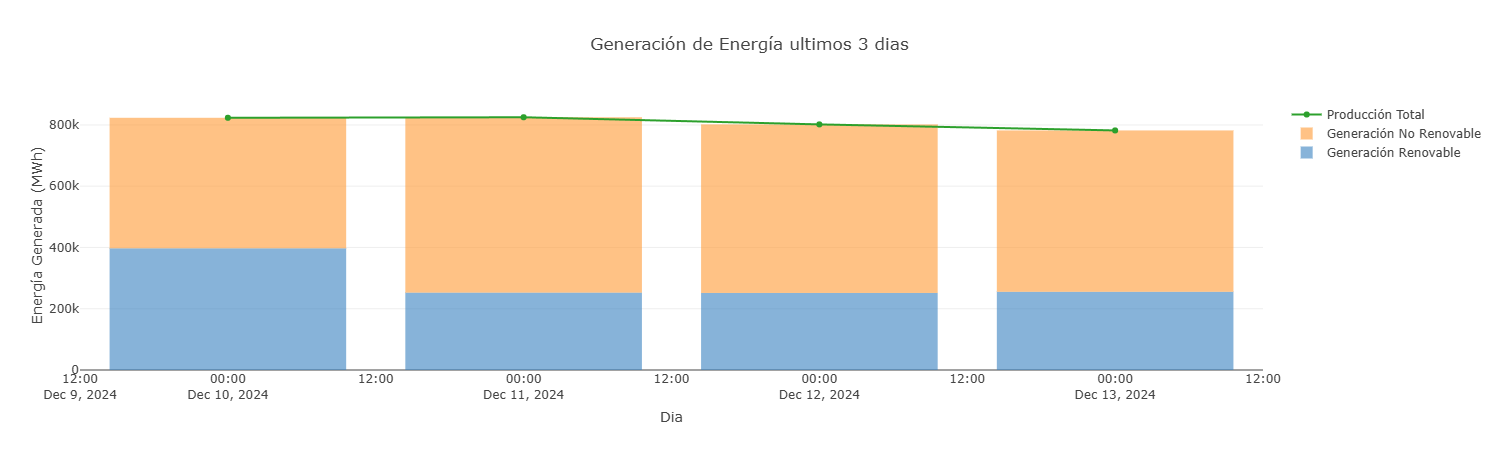

defined function analisisUltimos3dias

In [5]:
def analisisUltimos3dias (df: DataFrame): Unit = {
    val ultimos3dias = df
        .filter($"Fecha".isin("2024-12-10 00:00:00","2024-12-11 00:00:00","2024-12-12 00:00:00","2024-12-13 00:00:00"))
        .withColumn("Dia", to_date($"Fecha"))

    // Crear listas para el eje X (meses) y los valores para renovables y no renovables
    val dias = ultimos3dias.select("Dia").distinct().orderBy("Dia").as[String].collect.toSeq

    val renovables = ultimos3dias
      .filter($"Tipo" === "Generación renovable")
      .orderBy("Dia")
      .select("Valor")
      .as[Double]
      .collect
      .toSeq

    val noRenovables = ultimos3dias
      .filter($"Tipo" === "Generación no renovable")
      .orderBy("Dia")
      .select("Valor")
      .as[Double]
      .collect
      .toSeq

    val totalGenerado = ultimos3dias
        .filter($"Tipo" === "Generación renovable")
        .orderBy("Dia")
        .select("TotalGenerado")
        .as[Double]
        .collect
        .toSeq

    // Crear las barras para el gráfico
    val traceRenovables = Bar(
      x = dias,
      y = renovables,
      name = "Generación Renovable",
      marker = Marker(
        color = Color.RGBA(55, 128, 191, 0.6) // Color semitransparente para renovables
      )
    )

    val traceNoRenovables = Bar(
      x = dias,
      y = noRenovables,
      name = "Generación No Renovable",
      marker = Marker(
        color = Color.RGBA(255, 153, 51, 0.6) // Color semitransparente para no renovables
      )
    )

    val traceGeneracionTotal = Scatter(dias, totalGenerado, name = "Producción Total")

    // Configurar el diseño del gráfico
    val layout = Layout(
      title = "Generación de Energía ultimos 3 dias",
      barmode = BarMode.Stack, // Gráfico apilado
      xaxis = Axis(title = "Dia"),
      yaxis = Axis(title = "Energía Generada (MWh)")
    )

    // Combinar los datos y pintar el gráfico
    val data = Seq(traceRenovables, traceNoRenovables, traceGeneracionTotal)
    plot(data, layout)
}
analisisUltimos3dias(datosBalanceDiarios)

In [6]:
    val renovables = datosBalanceAnuales
        .filter($"Tipo" === "Generación renovable")
        .orderBy("Año")
        .select("ValorAnual")
        .as[Double]
        .collect
        .toSeq

collect at cmd5.sc:5

15 / 15

collect at cmd5.sc:5

200 / 200

collect at cmd5.sc:5

200 / 200

renovables: Seq[Double] = WrappedArray(
  8.666705284999998E7,
  8.533872275199999E7,
  1.0975765764349996E8,
  1.078761336995E8,
  9.408811295749995E7,
  1.0108916918450001E8,
  8.461086648700011E7,
  1.0034440521300003E8,
  9.791329882000001E7,
  1.10605198343E8,
  1.2145914631000003E8,
  1.1669521076699996E8,
  1.3464896426399994E8,
  1.4232141927199993E8
)

In [6]:
def analisisAnual(df: DataFrame): Unit = {
      
    val ultimos5años = df.filter($"Año".isin("2020", "2021", "2022", "2023", "2024"))

    // Seleccionar los años presentes en el DataFrame
    val años = ultimos5años.select("Año").distinct().orderBy("Año").as[String].collect.toSeq

    // Extraer valores de renovables, no renovables y total generado
    val renovables = ultimos5años
        .filter($"Tipo" === "Generación renovable")
        .orderBy("Año")
        .select("ValorAnual")
        .as[Double]
        .collect
        .toSeq

    val noRenovables = ultimos5años
        .filter($"Tipo" === "Generación no renovable")
        .orderBy("Año")
        .select("ValorAnual")
        .as[Double]
        .collect
        .toSeq

    
    val totalGenerado = ultimos5años
        .filter($"Tipo" === "Generación renovable")
        .orderBy("Año")
        .select("TotalGenerado")
        .as[Double]
        .collect
        .toSeq

     // Crear las barras para el gráfico
    val traceRenovables = Bar(
        x = años,
        y = renovables,
        name = "Generación Renovable",
        marker = Marker(
        color = Color.RGBA(55, 128, 191, 0.6) // Color semitransparente para renovables
        )
    )

    val traceNoRenovables = Bar(
        x = años,
        y = noRenovables,
        name = "Generación No Renovable",
        marker = Marker(
        color = Color.RGBA(255, 153, 51, 0.6) // Color semitransparente para no renovables
        )
    )

    val traceGeneracionTotal = Scatter(años, totalGenerado, name = "Producción Total")

    // Configurar el diseño del gráfico
    val layout = Layout(
      title = "Generación de Energía por Año",
      barmode = BarMode.Stack, // Gráfico apilado
      xaxis = Axis(title = "Año"),
      yaxis = Axis(title = "Energía Generada (MWh)")
    )

    // Combinar los datos y pintar el gráfico
    val data = Seq(traceRenovables, traceNoRenovables, traceGeneracionTotal)
    plot(data, layout)
   
}


// Llamar a la función con datos anuales
analisisAnual(datosBalanceAnuales)

collect at cmd5.sc:6

15 / 15

collect at cmd5.sc:6

200 / 200

collect at cmd5.sc:6

200 / 200

collect at cmd5.sc:6

200 / 200

collect at cmd5.sc:6

5 / 5

collect at cmd5.sc:13

15 / 15

collect at cmd5.sc:13

200 / 200

collect at cmd5.sc:13

200 / 200

collect at cmd5.sc:13

5 / 5

collect at cmd5.sc:21

15 / 15

collect at cmd5.sc:21

200 / 200

collect at cmd5.sc:21

200 / 200

collect at cmd5.sc:21

5 / 5

collect at cmd5.sc:30 
 (kill)

11 + 4 / 15

In [13]:
val porcentajeLimpiasAnual = datosBalanceAnuales
    .filter($"Tipo" === "Generación renovable")
    .withColumn("PorcentajeRedondeado", round($"PorcentajeSobreTotal", 2).cast("Int"))
    .withColumn("AñoInt", year($"Año")) // Extraer el año como entero
    .select($"AñoInt",$"Tipo", $"TotalGenerado", $"Porcentajeredondeado")
    .orderBy($"AñoInt")
porcentajeLimpiasAnual.show()

show at cmd12.sc:7

15 / 15

show at cmd12.sc:7

200 / 200

show at cmd12.sc:7

200 / 200

+------+--------------------+--------------+--------------------+
|AñoInt|                Tipo| TotalGenerado|Porcentajeredondeado|
+------+--------------------+--------------+--------------------+
|  2011|Generación renovable| 2.793538222E8|                  31|
|  2012|Generación renovable|2.8311864375E8|                  30|
|  2013|Generación renovable|2.7328624293E8|                  40|
|  2014|Generación renovable|2.6651174852E8|                  40|
|  2015|Generación renovable|2.6745384916E8|                  35|
|  2016|Generación renovable| 2.618356915E8|                  38|
|  2017|Generación renovable|2.6230575812E8|                  32|
|  2018|Generación renovable|2.6098190204E8|                  38|
|  2019|Generación renovable|2.6082883656E8|                  37|
|  2020|Generación renovable|2.5139875006E8|                  44|
|  2021|Generación renovable|2.6001118545E8|                  46|
|  2022|Generación renovable|2.7636791677E8|                  42|
|  2023|Ge

porcentajeLimpiasAnual: Dataset[Row] = [AñoInt: int, Tipo: string ... 2 more fields]

In [14]:
// Extraer la variable años
val años = porcentajeLimpiasAnual
   // Filtrar solo "Generación renovable"
  .select($"AñoInt") // Seleccionar la columna Año
  .as[Int] // Convertir directamente a Int
  .collect() // Recolectar los datos en el driver
  .toSeq // Convertir a Seq

// Extraer la variable renovables como Int
val renovables = porcentajeLimpiasAnual // Filtrar solo "Generación renovable"
  .select($"Porcentajeredondeado") // Seleccionar la columna Porcentajeredondeado
  .as[Int] // Forzar la conversión a Int
  .collect() // Recolectar los datos en el driver
  .toSeq // Convertir a Seq

collect at cmd13.sc:4

15 / 15

collect at cmd13.sc:4

200 / 200

collect at cmd13.sc:4

200 / 200

collect at cmd13.sc:4

14 / 14

collect at cmd13.sc:11

15 / 15

collect at cmd13.sc:11

200 / 200

collect at cmd13.sc:11

200 / 200

collect at cmd13.sc:11

200 / 200

años: Seq[Int] = WrappedArray(
  2011,
  2012,
  2013,
  2014,
  2015,
  2016,
  2017,
  2018,
  2019,
  2020,
  2021,
  2022,
  2023,
  2024
)
renovables: Seq[Int] = WrappedArray(
  31,
  30,
  40,
  40,
  35,
  38,
  32,
  38,
  37,
  44,
  46,
  42,
  50,
  56
)

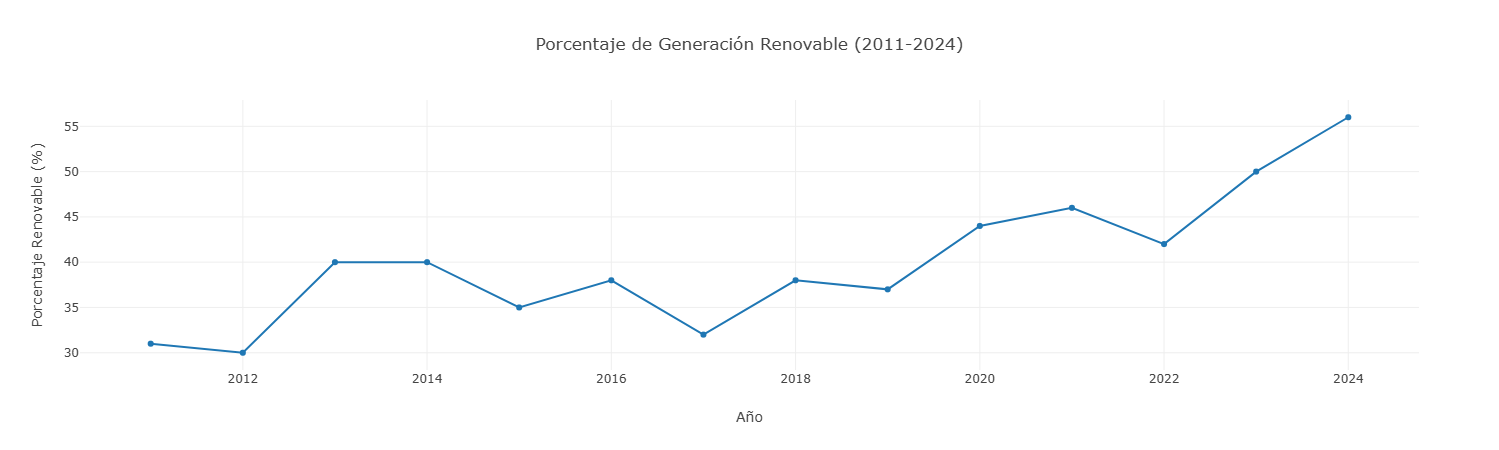

traceRenovables: Scatter = Scatter(
  Some(
    Doubles(
      ArrayBuffer(
        2011.0,
        2012.0,
        2013.0,
        2014.0,
        2015.0,
        2016.0,
        2017.0,
        2018.0,
        2019.0,
        2020.0,
        2021.0,
        2022.0,
        2023.0,
        2024.0
      )
    )
  ),
  Some(
    Doubles(
      ArrayBuffer(
        31.0,
        30.0,
        40.0,
        40.0,
        35.0,
        38.0,
        32.0,
        38.0,
        37.0,
        44.0,
        46.0,
        42.0,
        50.0,
        56.0
      )
...
layout: Layout = Layout(
  Some("Porcentaje de Generaci\u00f3n Renovable (2011-2024)"),
  None,
  None,
  None,
  None,
  Some(
    Axis(
      Some("A\u00f1o"),
      None,
      None,
      None,
      None,
      None,
      None,
      None,
      None,
      None,
      None,
      None,
      None,
      None,
      None,
      None,
      None,
      None,
      None,
      None,
      None,
      None,
      None,
      Non

In [52]:
// Crear el Scatter para la gráfica lineal
val traceRenovables = Scatter(
  años, 
  renovables, 
  //mode = ScatterMode(ScatterMode.Lines + ScatterMode.Markers), // Gráfica con líneas y puntos
  name = "Porcentaje Renovable"
)

// Configuración del Layout
val layout = Layout(
  title = "Porcentaje de Generación Renovable (2011-2024)",
  xaxis = Axis(title = "Año"),
  yaxis = Axis(
      title = "Porcentaje Renovable (%)"
  )
    

)

// Graficar
val data = Seq(traceRenovables)
plot(data,layout)

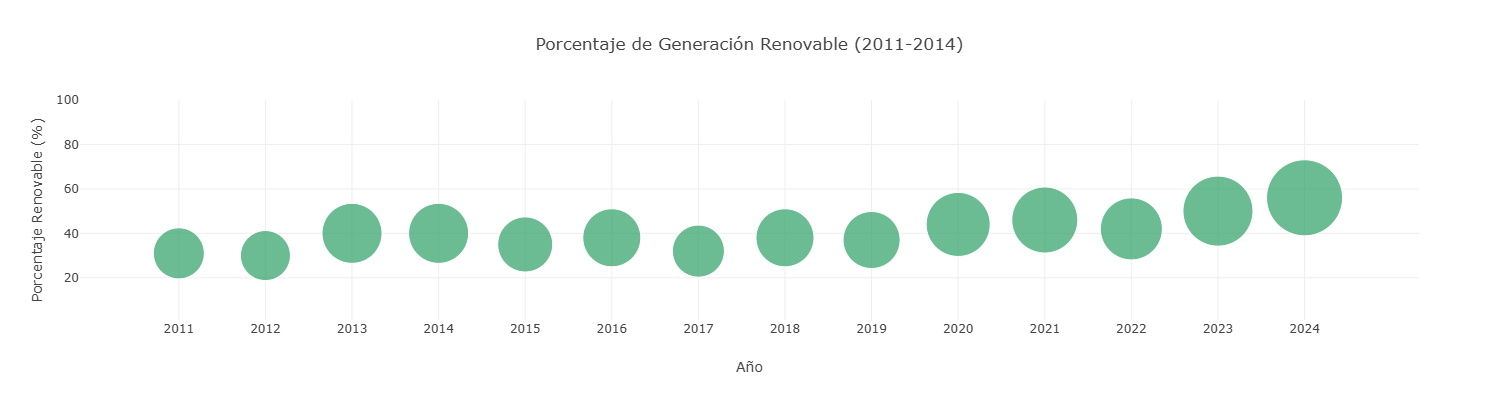

trace1: Scatter = Scatter(
  Some(
    Doubles(
      ArrayBuffer(
        2011.0,
        2012.0,
        2013.0,
        2014.0,
        2015.0,
        2016.0,
        2017.0,
        2018.0,
        2019.0,
        2020.0,
        2021.0,
        2022.0,
        2023.0,
        2024.0
      )
    )
  ),
  Some(
    Doubles(
      ArrayBuffer(
        31.0,
        30.0,
        40.0,
        40.0,
        35.0,
        38.0,
        32.0,
        38.0,
        37.0,
        44.0,
        46.0,
        42.0,
        50.0,
        56.0
      )
...
data: Seq[Scatter] = List(
  Scatter(
    Some(
      Doubles(
        ArrayBuffer(
          2011.0,
          2012.0,
          2013.0,
          2014.0,
          2015.0,
          2016.0,
          2017.0,
          2018.0,
          2019.0,
          2020.0,
          2021.0,
          2022.0,
          2023.0,
          2024.0
        )
      )
    ),
    Some(
      Doubles(
        ArrayBuffer(
          31.0,
          30.0,
      

In [48]:
val trace1 = Scatter(
  años,
  renovables,
  mode = ScatterMode(ScatterMode.Markers),
  marker = Marker(
    color = Color.RGB(44, 160, 101),
    size = renovables.map(_ + 20)
  )
)

val data = Seq(trace1)

val layout = Layout(
  title = "Porcentaje de Generación Renovable (2011-2014)",
  xaxis = Axis(
    title = "Año",
    tickvals = años
  ), // Título del eje X
  yaxis = Axis(
    title = "Porcentaje Renovable (%)", // Título del eje Y
    range = (1.0, 100.0) // Fijar el rango del eje Y de 1 a 100 como un par de Doubles
  ),
  showlegend = false, // Ocultar leyenda
  height = 400, // Altura del gráfico
  width = 1500 // Anchura del gráfico
)


plot(data, layout)
